# Demonstration of soScope working on Gaussian distribution

This is a demonstration of soScope analysis on simulated data with Gaussian distribution.

Bohan Li @ Deng ai Lab @ BUAA 2023.

Software provided as is under MIT License.

In [21]:
import os
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

from soScope_model.train import two_step_train
from soScope_model.inference import infer

def seed_all(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_all(0)

## Scene Preset

Experiment: Liver tumor tissue multi-scale resolution enhancement experiment. We show the challenging case that enhancing resolution from data with a low resolution 12x12 here.

Inputs: 12x12 “low-resolution” spots with aggregated DNA PCs (X), morphological image features generated from a pretrained Inception-v3 model at high-resolution (Y), and spatial neighboring relations (A)

Outputs: Enhanced DNA PCs of 60x60 “enhanced-resolution” spots compared to spots with original resolution merged form slide-DNA-seq raw data.

PCs analyzed: DNA PC1 for clone A region, DNA PC2 for clone B region.



In [22]:
# Train model
# vgae_experiment_dir: saving directory for pre-training stage.
# soScope_experiment_dir: saving directory soScope training.
# data_dir: dataset directory contains necessary data mentioned above.
# vgae_config_file: model configuration for variational graph auto-encoder used in pre-training stage.
# soScope_config_file: model configuration for soScope.
# device, checkpoint_every, backup_every, epochs: default training settings.
# num_neighbors: edges are built between every neighboring 4 nodes, not to be revised.

two_step_train(logging=not None,
                 vgae_experiment_dir='experiments/VGAE_Gaussian',
                 soScope_experiment_dir='experiments/soScope_Gaussian',
                 data_dir='DataSet/Gaussian_x5_demo/',
                 vgae_config_file='config/Gaussian_x5/VGAE.yml',
                 soScope_config_file='config/Gaussian_x5/soScope.yml',
                 device='cuda',
                 checkpoint_every=1000,
                 backup_every=200,
                 epochs=[10000, 10000],
                 num_neighbors=4
                            )


Step 1
<class 'soScope_model.training.vgae.VGAETrainer'>
===There are 144 nodes to train.===
Sub Data Loaded
We built edges between every neighboring 4 nodes
Spatial Data Loaded
Dataset loaded!
========== Initialization the graph encoder ============


100%|██████████| 10000/10000 [01:56<00:00, 85.73it/s]


Step 2
<class 'soScope_model.training.svae_Global_Gaussian.soScope_Gaussian'>
Pretrained Model Loaded!
========== Optimization of soScope ============


100%|██████████| 10000/10000 [03:16<00:00, 50.86it/s]


In [23]:
# Inference enhanced expression
# experiment_dir: saving directory for inference stage.
# non_negative, device: default training settings.
# num_neighbors: edges are built between every neighboring 4 nodes, not to be revised.
# data_dir: dataset directory contains necessary data mentioned above.
# result_dir: saving directory for results.

infer(
        experiment_dir= 'experiments/soScope_Gaussian',
        non_negative=True,
        num_neighbors=4,
        data_dir= 'DataSet/Gaussian_x5_demo/',
        result_dir='DataSet/Gaussian_x5_demo/',
        device='cuda',
)

<class 'soScope_model.training.svae_Global_Gaussian.soScope_Gaussian'>
Pretrained Model Loaded!
We built edges between every neighboring 4 nodes
Spatial Data Loaded


In [24]:
# Visualization
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ari
from scipy.optimize import linear_sum_assignment

# Load results from dist
# lr_count, position: merged data with positions contains column (x) and row (y) index.
# original_count, en_position: enhanced data with positions contains column (en_x) and row (en_y) index.
# hr_count: soScope data.

lr_count = np.load(f'DataSet/Gaussian_x5_demo/label.npy')
position = pd.read_csv(f'DataSet/Gaussian_x5_demo/colData_merge.csv')
x = position['col'].tolist()
y = position['row'].tolist()

en_position = pd.read_csv(f'DataSet/Gaussian_x5_demo/reordered_position_with_center.csv')
en_x = en_position['col'].tolist()
en_y = en_position['row'].tolist()

original_count_df = pd.read_csv(f'DataSet/Gaussian_x5_demo/reordered_count.csv')
original_count = original_count_df.values

hr_count = np.load(f'DataSet/Gaussian_x5_demo/infer_subspot.npy')

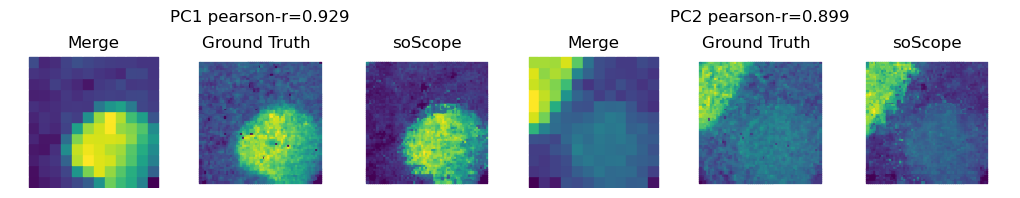

In [25]:
# Simulated resolution enhancement visualization. 
# Visualized data: DNA PC1 for clone A region, DNA PC2 for clone B region.
# pearson-r: pearson correlation score calculated from soScope data and Ground Truth. 
# arrangment in subplot: merged data (left) at low resolution, ground truth data (middle) and scScope (right) predicted data at enhanced resolution

cmap = 'viridis'
fig = plt.figure(figsize=(15, 5), dpi=100)
gene_names = ['PC1', 'PC2']

for idx in range(2):
    # merged data visualization
    pearson_r, _ = pearsonr(original_count[:, idx], hr_count[:, idx])
    gene_name = gene_names[idx]
    ax = fig.add_subplot(3, 9, 3*idx+1)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(x, y, s=50,
                marker = 's',
                c=lr_count[:, idx],
                cmap=cmap,
                )
    plt.title('Merge', y=1)
    
    # ground truth data visualization
    ax = fig.add_subplot(3, 9, 3*idx+2)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_x, en_y, s=1,
                marker='s',
                c=original_count[:, idx],
                cmap=cmap,
                )
    plt.title(gene_name+' pearson-r={:.3f}'.format(pearson_r),y=1.2)
    plt.title('Ground Truth', loc='left',y=1, x=0.15)
    
    # soScope predicted data visualization
    ax = fig.add_subplot(3, 9, 3*idx+3)
    plt.axis("equal")
    plt.axis('off')
    plt.scatter(en_x, en_y, s=1,
                marker='s',
                c=hr_count[:, idx],
                cmap=cmap,
                )
    plt.title('soScope', y=1)
    
fig.subplots_adjust(left=0,right=1,top=1,bottom=0,
                    wspace=0,hspace=0.4)
plt.show()

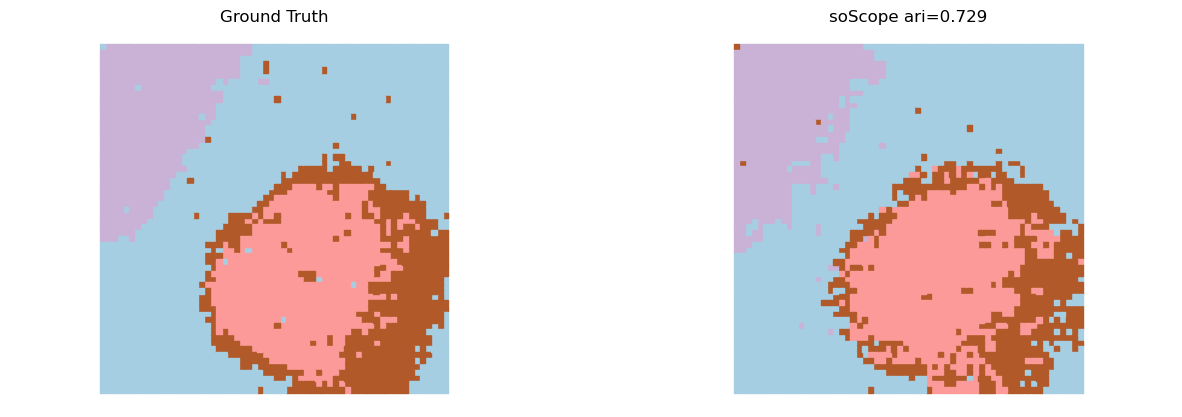

In [26]:
# Tissue structure identification via k-means clustering on data at enhanced resolution
# clusters number: 4
# ari: adjusted Rand index for measurement of consistency between the clustering result and ground truth
# left: cluster result based on ground truth data
# right cluster result based on soScope predicted data

def map_label(original_label, my_label):
    original_label_class_num = len(np.unique(original_label))
    my_label_class_num = len(np.unique(my_label))

    c_mat = np.zeros((original_label_class_num, my_label_class_num))
    for i in range(original_label_class_num):
        for j in range(my_label_class_num):
            c_mat[i, j] = ari((original_label==i).reshape(-1), (my_label==j).reshape(-1))

    goodAt = c_mat
    weakAt = np.max(c_mat) + 1 -goodAt
    row_ind,col_ind=linear_sum_assignment(weakAt)

    class_map = {}
    for i in range(len(row_ind)):
        class_map[col_ind[i]] = row_ind[i]

    return np.array([class_map[l] for l in my_label.tolist()])

kmeans = KMeans(n_clusters=4, random_state=0, n_init=10, algorithm='elkan')

# plot cluster result based on ground truth data
fig = plt.figure(figsize=(15, 5), dpi=100)
ax = fig.add_subplot(1, 2, 1)
plt.axis("equal")
plt.axis('off')
original_count_ = original_count[:, 0:2]
original_label = kmeans.fit(original_count_.reshape(-1, 2)).labels_
plt.scatter(en_x, en_y, s=15,
            marker = 's',
            c=original_label,
            cmap='Paired',
            )
plt.title('Ground Truth', y=1)

# plot cluster result based on soScope predicted data
ax = fig.add_subplot(1, 2, 2)
plt.axis("equal")
plt.axis('off')
hr_count_ = hr_count[:, 0:2]
my_label = kmeans.fit(hr_count_.reshape(-1, 2)).labels_
mapped_label = map_label(original_label, my_label)
plt.scatter(en_x, en_y, s=15,
            marker = 's',
            c=mapped_label,
            cmap='Paired',
            )
ari_score = ari(original_label, my_label)
plt.title('soScope ari={:.3f}'.format(ari_score), y=1)

plt.show()